In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import gensim
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from keras.utils import to_categorical
import matplotlib.pyplot as plt 
import keras
from time import time

In [ ]:
df = pd.read_csv("data/preprocessed_train.csv")
df

,textID,text,selected_text,sentiment
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview leave me alone,leave me alone,negative
4,358bd9e861,sons of why couldnt they put them on the rele...,sons of,negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband los...,d lost,negative
27477,4f4c4fc327,ive wondered about rake to the client has made...,dont force,negative
27478,f67aae2310,yay good for both of you enjoy the break you p...,yay good for both of you,positive
27479,ed167662a5,but it was worth it,but it was worth it,positive


In [ ]:
# for case 1 run this code (case 1 = text)
case = "case1-bilstm"

#read data
df = pd.read_csv("data/preprocessed_train.csv")
df.text = df.text.map(lambda x:str(x))
df.sentiment = df.sentiment.astype("category")
df.sentiment = df.sentiment.cat.codes

In [ ]:
# for case 2 run this code (case 2 = selected text)
case = "case2-bilstm"

#read data
df = pd.read_csv("data/preprocessed_train.csv")
df.text = df.selected_text.map(lambda x:str(x))
df.sentiment = df.sentiment.astype("category")
df.sentiment = df.sentiment.cat.codes

In [ ]:
# train, val, test split
x_train, xtest, y_train, ytest = train_test_split(df.text.values, df.sentiment.values,stratify=df.sentiment.values, test_size=0.3,random_state=1)
y_train = to_categorical(y_train)
x_val = xtest[0:4122]
y_val = to_categorical(ytest[0:4122])
x_test = xtest[4122:]
y_test = ytest[4122:]

#padding and tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df.text.values)

X_train = tokenizer.texts_to_sequences(x_train)
X_val = tokenizer.texts_to_sequences(x_val)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='pre', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='pre', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen)

word_index = tokenizer.word_index

In [ ]:
#import glove embeddings

embeddings_index = {}
f = open(os.path.join( 'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
#using glove

from keras.models import Sequential
from keras import regularizers
from keras.layers.core import Dense, Dropout, Flatten
from keras import layers
from sklearn.metrics import accuracy_score, f1_score
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D


def bilstm_glove(activation,optimizer,epochs,batchsize):
  embedding_dim = 100

  model = Sequential()
  model.add(layers.Embedding(input_dim=vocab_size, 
                          output_dim=embedding_dim, weights=[embedding_matrix],
                          input_length=maxlen))
  model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
  model.add(Dense(3,activation='softmax'))
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_val, y_val),
                    batch_size=batchsize)
  
  return history, model

In [ ]:
activation = [ "tanh"]
optimizer = ["adam", "SGD", "RMSprop", "Adadelta"]
epochs = [5,10,15,20]
batchsize = [8,16,32,64,128]

129/129 [==============================] - 1s 6ms/step - loss: 0.6326 - accuracy: 0.7458
best activation function is  tanh
129/129 [==============================] - 1s 7ms/step - loss: 1.1151 - accuracy: 0.3222
best optimizer is  adam
129/129 [==============================] - 1s 6ms/step - loss: 0.7270 - accuracy: 0.7285
best epoch is  5
129/129 [==============================] - 1s 6ms/step - loss: 0.6612 - accuracy: 0.7276
best batchsize is  16
test accuracy score =  0.7395100654862964
test f1 score =  0.739932252679558
time taken is  183.4457392692566


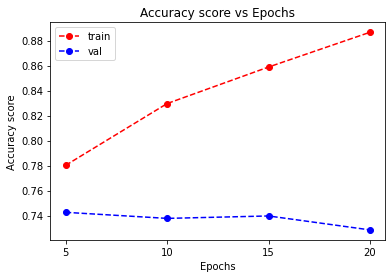

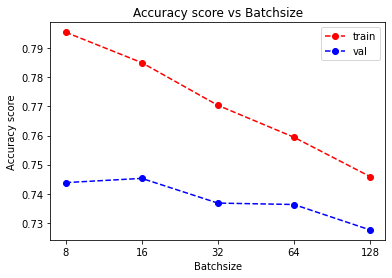

In [ ]:
#experiments using glove embeddings

# 1. selecting activation fixing - optimizer = adam, epochs = 5, batch = 16
sel_activation = {}
for i in activation:
  history, model = bilstm_glove(i,"adam",5,16)
  temp = {i:model.evaluate(X_val,y_val)[1]}
  sel_activation.update(temp)
  keras.backend.clear_session()

sel_activation_final = max(sel_activation, key=sel_activation.get)
print("best activation function is ",sel_activation_final)

# 2. selecting optimizer by fixing - activation = best, epochs = 5, batch = 16
sel_optimizer = {}
for i in optimizer:
  history, model = bilstm_glove(sel_activation_final,i,5,16)
  temp = {i:model.evaluate(X_val,y_val)[1]}
  sel_optimizer.update(temp)
  keras.backend.clear_session()

sel_optimizer_final = max(sel_optimizer, key=sel_optimizer.get)
print("best optimizer is ",sel_optimizer_final)

# 3.  graph epoch vs accuracy score

acc_train_epoch = {}
acc_val_epoch = {}
for i in epochs:
  history, model = bilstm_glove(sel_activation_final,sel_optimizer_final,i,16)
  temp_train = {i:model.evaluate(X_train,y_train)[1]}
  temp_val = {i:model.evaluate(X_val,y_val)[1]}
  acc_train_epoch.update(temp_train)
  acc_val_epoch.update(temp_val)
  keras.backend.clear_session()

sel_epoch_final = max(acc_val_epoch, key=acc_val_epoch.get)
print("best epoch is ",sel_epoch_final)

df_epoch_train = pd.DataFrame(list(acc_train_epoch.items()), columns=['Epochs', 'Accuracy score'])
df_epoch_val = pd.DataFrame(list(acc_val_epoch.items()), columns=['Epochs', 'Accuracy score'])

df_epoch_val.Epochs = df_epoch_val.Epochs.map(lambda x:str(x))
df_epoch_train.Epochs = df_epoch_train.Epochs.map(lambda x:str(x))


plt.figure()
plt.plot(df_epoch_train.iloc[:,0],df_epoch_train.iloc[:,1],c="r",label="train",linestyle='--', marker='o')
plt.plot(df_epoch_val.iloc[:,0],df_epoch_val.iloc[:,1],c="b",label = "val",linestyle='--', marker='o')
plt.title("Accuracy score vs Epochs")
plt.ylabel("Accuracy score")
plt.xlabel("Epochs")
plt.legend()
plt.savefig("images/acc-epoch-glove-"+case, bbox_inches='tight',dpi = 200)


# 4. graph batch size vs accuracy score
acc_train_batch = {}
acc_val_batch = {}
for i in batchsize:
  history, model = bilstm_glove(sel_activation_final,sel_optimizer_final,sel_epoch_final,i)
  temp_train = {i:model.evaluate(X_train,y_train)[1]}
  temp_val = {i:model.evaluate(X_val,y_val)[1]}
  acc_train_batch.update(temp_train)
  acc_val_batch.update(temp_val)
  keras.backend.clear_session()

sel_batch_final = max(acc_val_batch, key=acc_val_batch.get)
print("best batchsize is ",sel_batch_final)

df_batch_train = pd.DataFrame(list(acc_train_batch.items()), columns=['Batchsize', 'Accuracy score'])
df_batch_val = pd.DataFrame(list(acc_val_batch.items()), columns=['Batchsize', 'Accuracy score'])

df_batch_val.Batchsize = df_batch_val.Batchsize.map(lambda x:str(x))
df_batch_train.Batchsize = df_batch_train.Batchsize.map(lambda x:str(x))

plt.figure()
plt.plot(df_batch_train.iloc[:,0],df_batch_train.iloc[:,1],c="r",label="train",linestyle='--', marker='o')
plt.plot(df_batch_val.iloc[:,0],df_batch_val.iloc[:,1],c="b",label = "val",linestyle='--', marker='o')
plt.title("Accuracy score vs Batchsize")
plt.ylabel("Accuracy score")
plt.xlabel("Batchsize")
plt.legend()
plt.savefig("images/acc-batch-glove-"+case, bbox_inches='tight',dpi = 200)

# 5. best model
t0 = time()
history, model = bilstm_glove(sel_activation_final,sel_optimizer_final,sel_epoch_final,sel_batch_final)
pred = np.argmax(model.predict(X_test), axis=-1)
print("test accuracy score = ",accuracy_score(y_pred=pred, y_true=y_test))
print("test f1 score = ",f1_score(y_pred=pred, y_true=y_test, average="weighted"))

t1 = time()
print("time taken is ", t1-t0)

In [ ]:
#using keras embedding

def bilstm_keras(activation,optimizer,epochs,batchsize):
  embedding_dim = 100

  model = Sequential()
  model.add(layers.Embedding(input_dim=vocab_size, 
                          output_dim=embedding_dim, 
                          input_length=maxlen))
  model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
  model.add(Dense(3,activation='softmax'))
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_val, y_val),
                    batch_size=batchsize)
  
  return history, model

129/129 [==============================] - 1s 6ms/step - loss: 0.6990 - accuracy: 0.7149
best activation function is  tanh
129/129 [==============================] - 1s 6ms/step - loss: 1.0912 - accuracy: 0.4129
best optimizer is  RMSprop
129/129 [==============================] - 1s 6ms/step - loss: 0.7221 - accuracy: 0.7244
best epoch is  5
129/129 [==============================] - 1s 6ms/step - loss: 0.7031 - accuracy: 0.7069
best batchsize is  32
test accuracy score =  0.7135580887703129
test f1 score =  0.7152900471980079
time taken is  59.98751258850098


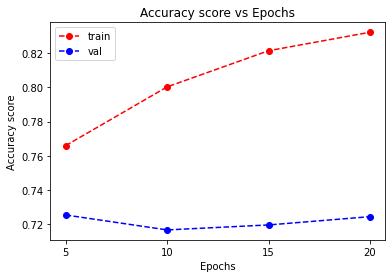

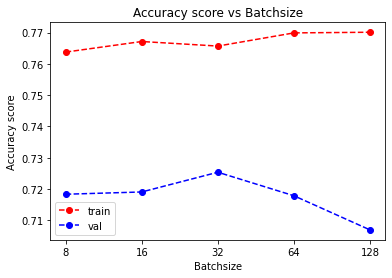

In [ ]:
#experiments using keras embeddings

# 1. selecting activation fixing - optimizer = adam, epochs = 5, batch = 16
sel_activation = {}
for i in activation:
  history, model = bilstm_keras(i,"adam",5,16)
  temp = {i:model.evaluate(X_val,y_val)[1]}
  sel_activation.update(temp)
  keras.backend.clear_session()

sel_activation_final = max(sel_activation, key=sel_activation.get)
print("best activation function is ",sel_activation_final)

# 2. selecting optimizer by fixing - activation = best, epochs = 5, batch = 16
sel_optimizer = {}
for i in optimizer:
  history, model = bilstm_keras(sel_activation_final,i,5,16)
  temp = {i:model.evaluate(X_val,y_val)[1]}
  sel_optimizer.update(temp)
  keras.backend.clear_session()

sel_optimizer_final = max(sel_optimizer, key=sel_optimizer.get)
print("best optimizer is ",sel_optimizer_final)

# 3.  graph epoch vs accuracy score

acc_train_epoch = {}
acc_val_epoch = {}
for i in epochs:
  history, model = bilstm_keras(sel_activation_final,sel_optimizer_final,i,16)
  temp_train = {i:model.evaluate(X_train,y_train)[1]}
  temp_val = {i:model.evaluate(X_val,y_val)[1]}
  acc_train_epoch.update(temp_train)
  acc_val_epoch.update(temp_val)
  keras.backend.clear_session()

sel_epoch_final = max(acc_val_epoch, key=acc_val_epoch.get)
print("best epoch is ",sel_epoch_final)

df_epoch_train = pd.DataFrame(list(acc_train_epoch.items()), columns=['Epochs', 'Accuracy score'])
df_epoch_val = pd.DataFrame(list(acc_val_epoch.items()), columns=['Epochs', 'Accuracy score'])

df_epoch_val.Epochs = df_epoch_val.Epochs.map(lambda x:str(x))
df_epoch_train.Epochs = df_epoch_train.Epochs.map(lambda x:str(x))

plt.figure()
plt.plot(df_epoch_train.iloc[:,0],df_epoch_train.iloc[:,1],c="r",label="train",linestyle='--', marker='o')
plt.plot(df_epoch_val.iloc[:,0],df_epoch_val.iloc[:,1],c="b",label = "val",linestyle='--', marker='o')
plt.title("Accuracy score vs Epochs")
plt.ylabel("Accuracy score")
plt.xlabel("Epochs")
plt.legend()
plt.savefig("images/acc-epoch-keras-"+case, bbox_inches='tight',dpi = 200)


# 4. graph batch size vs accuracy score
acc_train_batch = {}
acc_val_batch = {}
for i in batchsize:
  history, model = bilstm_keras(sel_activation_final,sel_optimizer_final,sel_epoch_final,i)
  temp_train = {i:model.evaluate(X_train,y_train)[1]}
  temp_val = {i:model.evaluate(X_val,y_val)[1]}
  acc_train_batch.update(temp_train)
  acc_val_batch.update(temp_val)
  keras.backend.clear_session()

sel_batch_final = max(acc_val_batch, key=acc_val_batch.get)
print("best batchsize is ",sel_batch_final)

df_batch_train = pd.DataFrame(list(acc_train_batch.items()), columns=['Batchsize', 'Accuracy score'])
df_batch_val = pd.DataFrame(list(acc_val_batch.items()), columns=['Batchsize', 'Accuracy score'])

df_batch_val.Batchsize = df_batch_val.Batchsize.map(lambda x:str(x))
df_batch_train.Batchsize = df_batch_train.Batchsize.map(lambda x:str(x))

plt.figure()
plt.plot(df_batch_train.iloc[:,0],df_batch_train.iloc[:,1],c="r",label="train",linestyle='--', marker='o')
plt.plot(df_batch_val.iloc[:,0],df_batch_val.iloc[:,1],c="b",label = "val",linestyle='--', marker='o')
plt.title("Accuracy score vs Batchsize")
plt.ylabel("Accuracy score")
plt.xlabel("Batchsize")
plt.legend()
plt.savefig("images/acc-batch-keras-"+case, bbox_inches='tight',dpi = 200)

# 5. best model
t0 = time()
history, model = bilstm_keras(sel_activation_final,sel_optimizer_final,sel_epoch_final,sel_batch_final)
pred = np.argmax(model.predict(X_test), axis=-1)
print("test accuracy score = ",accuracy_score(y_pred=pred, y_true=y_test))
print("test f1 score = ",f1_score(y_pred=pred, y_true=y_test, average="weighted"))

t1 = time()
print("time taken is ", t1-t0)